In [45]:
import sys 
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

In [64]:
from __future__ import division
from itertools import combinations
from collections import Counter


class Omega:
    def __init__(self, comms1, comms2):
        self.nodes1 = self.get_node_assignment(comms1)
        self.nodes2 = self.get_node_assignment(comms2)
        self.nodes = list(set().union([node for i, com in comms2.items() for node in com],
                                      [node for i, com in comms1.items() for node in com]))
        J, K, N, obs, tuples1, tuples2 = self.observed()
        exp = self.expected(J, K, N, tuples1, tuples2)
        self.omega_score = self.calc_omega(obs, exp)

    def get_node_assignment(self, comms):
        """
        returns a dictionary with node-cluster assignments of the form {node_id :[cluster1, cluster_3]}
        :param comms:
        :return:
        """
        nodes = {}
        for i, com in comms.items():
            for node in com:
                try:
                    nodes[node].append(i)
                except KeyError:
                    nodes[node] = [i]
        return nodes

    def num_of_common_clusters(self, u, v, nodes_dict):
        """
        return the number of clusters in which the pair u,v appears in the
        :param u:
        :param v:
        :param nodes_dict:
        :return:
        """
        try:
            _sum = len(set(nodes_dict[u]) & set(nodes_dict[v]))
        except KeyError:
            _sum = 0
        return _sum

    def observed(self):
        N = 0
        tuples1 = {}
        J = 0
        for u, v in combinations(self.nodes, 2):
            N += 1
            n = self.num_of_common_clusters(u, v, self.nodes1)
            tuples1[(u, v)] = self.num_of_common_clusters(u, v, self.nodes1)
            J = n if n > J else J
        tuples2 = {}
        K = 0
        for u, v in combinations(self.nodes, 2):
            n = self.num_of_common_clusters(u, v, self.nodes2)
            tuples2[(u, v)] = self.num_of_common_clusters(u, v, self.nodes2)
            K = n if n > K else K
        obs = 0
        A = {j: 0 for j in range(min(J, K)+1)}
        for (u, v), n in tuples1.items():
            try:
                if n == tuples2[(u, v)]:
                    A[n] += 1
            except KeyError:
                pass
        obs = sum(A[j]/N for j in range(min(J, K)+1))
        return J, K, N, obs, tuples1, tuples2

    def expected(self, J, K, N, tuples1, tuples2):
        N1 = Counter(tuples1.values())
        N2 = Counter(tuples2.values())
        exp = sum((N1[j]*N2[j])/(N**2) for j in range(min(J, K)+1))
        return exp

    def calc_omega(self, obs, exp):
        if exp == obs == 1:
            return 1.0
        else:
            return (obs-exp)/(1-exp)

In [84]:
class NF1(object):
    def __init__(self, communities, ground_truth):
        self.matched_gt = {}
        self.gt_count = 0
        self.id_count = 0
        self.gt_nodes = {}
        self.id_nodes = {}
        self.communities = communities
        self.ground_truth = ground_truth
        self.prl = []
        #self.__compute_precision_recall()

    def get_f1(self):
        """
        :param prl: list of tuples (precision, recall)
        :return: a tuple composed by (average_f1, std_f1)
        """

        # gt_coms = {cid: nodes for cid, nodes in enumerate(self.ground_truth)}
        gt_coms = self.ground_truth
        # ext_coms = {cid: nodes for cid, nodes in enumerate(self.communities)}
        ext_coms = self.communities

        f1_list = []
        for cid, nodes in gt_coms.items():
            tmp = [self.__compute_f1(nodes2, nodes) for _, nodes2 in ext_coms.items()]
            f1_list.append(np.max(tmp))

        f2_list = []
        for cid, nodes in ext_coms.items():
            tmp = [self.__compute_f1(nodes, nodes2) for _, nodes2 in gt_coms.items()]
            f2_list.append(np.max(tmp))

        
        # print(f1_list, f2_list)
        return (np.mean(f1_list) + np.mean(f2_list))/2

    def __compute_f1(self, c, gt):
        c = set(c)
        gt = set(gt)

        try:
            precision = len([x for x in c if x in gt ])/len(c)
            recall = len([x for x in gt if x in c ])/len(gt) 
            x, y = precision, recall
            z = 2 * (x * y) / (x + y)
            z = float("%.2f" % z)
            return z
        except ZeroDivisionError:
            return 0.

In [88]:
def calc_jaccard(num_vertices, ext_coms, gt_coms):
    def func(s1, s2):
        s1, s2 = set(s1), set(s2)
        return len(s1.intersection(s2)) / len(s1.union(s2))

    f1_list = []
    for _, nodes in gt_coms.items():
        tmp = [func(nodes2, nodes) for _, nodes2 in ext_coms.items()]
        f1_list.append(np.max(tmp))

    f2_list = []
    for _, nodes in ext_coms.items():
        tmp = [func(nodes, nodes2) for _, nodes2 in gt_coms.items()]
        f2_list.append(np.max(tmp))
    return (np.mean(f1_list) + np.mean(f2_list))/2

In [47]:
num_subjects = 300
num_nodes = 360
num_communities = 16
test_idx = 0

In [48]:
functional_networks = pd.read_csv(Path("../data/brain_regions.csv"))
ukb_communities = np.load(Path("/Users/simeonspasov/Downloads/embeddings/ukb/embeddings.npy"), allow_pickle=True).item()
hcp_communities = np.load(Path("/Users/simeonspasov/Downloads/embeddings/hcp/embeddings.npy"), allow_pickle=True).item()

In [49]:
dataset_community_distribution = ukb_communities

community_distribution = np.zeros((num_communities, num_nodes))
for subject_id in range(num_subjects):
    community_distribution += dataset_community_distribution[subject_id]['node_distribution_over_communities']['test'][test_idx]

community_distribution /= num_subjects  
print(community_distribution)
    

[[0.00662472 0.003827   0.00753548 ... 0.00058272 0.00071456 0.00145478]
 [0.00438073 0.00191676 0.00439327 ... 0.00045654 0.00074566 0.00103995]
 [0.00772884 0.00371892 0.00503621 ... 0.0005396  0.00180195 0.00352099]
 ...
 [0.00984857 0.00379374 0.00573029 ... 0.00043191 0.00127644 0.00248172]
 [0.0065156  0.00236134 0.00376983 ... 0.00026077 0.00207815 0.00127526]
 [0.00308981 0.0028085  0.00320351 ... 0.00086219 0.00057    0.00108739]]


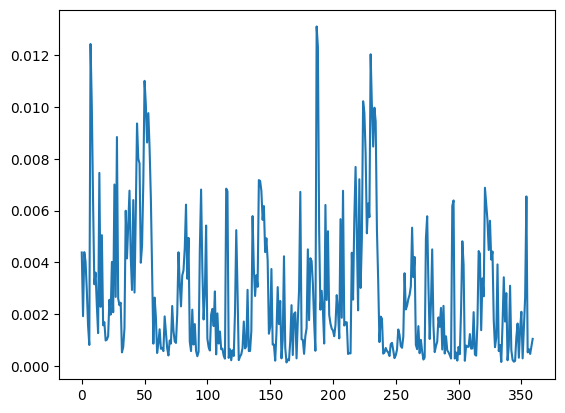

In [91]:
community_idx = 1
plt.plot(community_distribution[community_idx])

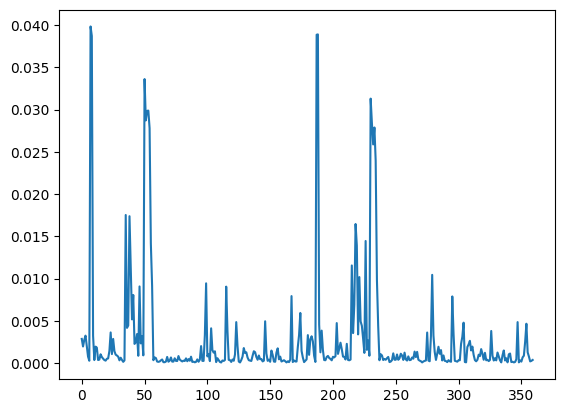

In [92]:
plt.plot(dataset_community_distribution[0]['node_distribution_over_communities']['test'][test_idx][community_idx])

In [60]:
retain_percentile = 90

communities = {}
for c in range(len(community_distribution)):
    top_percentile = np.percentile(community_distribution[c], retain_percentile)
    communities[c] = [node_idx for node_idx, node_value in enumerate(community_distribution[c]) if node_value >= top_percentile]

print (communities)

{0: [0, 2, 3, 9, 14, 16, 24, 26, 28, 37, 41, 44, 45, 46, 47, 49, 137, 139, 141, 142, 145, 174, 180, 182, 183, 196, 206, 217, 221, 224, 225, 226, 321, 322, 325, 354], 1: [7, 8, 14, 26, 28, 38, 44, 45, 46, 49, 50, 51, 52, 53, 54, 95, 115, 116, 141, 142, 143, 174, 187, 188, 208, 218, 221, 224, 225, 226, 230, 231, 232, 233, 234, 321], 2: [0, 3, 4, 5, 7, 8, 12, 25, 35, 50, 52, 129, 138, 180, 183, 184, 185, 187, 188, 191, 192, 205, 207, 222, 230, 232, 233, 248, 253, 254, 255, 265, 266, 309, 318, 319], 3: [13, 29, 32, 33, 34, 66, 67, 68, 69, 70, 71, 72, 76, 86, 96, 97, 131, 132, 133, 144, 148, 149, 150, 160, 169, 176, 194, 209, 213, 214, 246, 247, 328, 329, 330, 340], 4: [14, 26, 28, 29, 66, 72, 76, 78, 80, 82, 83, 84, 85, 88, 96, 132, 136, 138, 139, 142, 143, 144, 145, 148, 150, 169, 194, 208, 224, 225, 263, 264, 316, 323, 324, 328], 5: [0, 2, 3, 4, 5, 6, 12, 15, 17, 18, 19, 20, 21, 47, 151, 155, 157, 158, 180, 182, 183, 184, 185, 186, 192, 195, 197, 198, 199, 200, 201, 331, 333, 335, 337, 3

In [61]:
ground_truth_communities = functional_networks.groupby('network_idx')['region_idx'].apply(list).to_dict()
print (ground_truth_communities)

{1: [0, 120, 141, 180, 300, 321], 2: [1, 2, 3, 4, 5, 6, 12, 15, 16, 17, 18, 19, 20, 21, 22, 47, 48, 137, 151, 152, 153, 155, 156, 157, 158, 159, 162, 181, 182, 183, 184, 185, 186, 192, 195, 196, 197, 198, 199, 200, 201, 202, 227, 228, 317, 331, 332, 333, 335, 336, 337, 338, 339, 342], 3: [7, 8, 35, 38, 39, 40, 41, 46, 50, 51, 52, 53, 54, 55, 99, 100, 101, 103, 114, 167, 187, 188, 215, 218, 219, 220, 221, 226, 230, 231, 232, 233, 234, 235, 279, 280, 281, 294, 347], 4: [9, 10, 24, 36, 37, 42, 43, 44, 56, 58, 59, 77, 81, 83, 85, 98, 104, 105, 107, 108, 112, 113, 146, 147, 166, 168, 177, 178, 179, 189, 216, 217, 222, 223, 224, 236, 237, 238, 239, 257, 263, 265, 278, 284, 285, 287, 288, 292, 293, 326, 327, 346, 348, 357, 358, 359], 5: [45, 49, 94, 95, 115, 116, 126, 135, 136, 142, 145, 190, 225, 229, 274, 275, 295, 296, 306, 315, 316, 322, 325], 6: [11, 25, 74, 78, 122, 124, 128, 138, 171, 191, 204, 205, 207, 253, 254, 258, 260, 302, 304, 307, 308, 318, 351], 7: [13, 14, 28, 57, 61, 62, 72,

In [66]:
omega = Omega(communities, ground_truth_communities)
print(omega.omega_score)

0.1477783650189298


In [71]:
combs = list(combinations(range(16), 12))

comb = combs[0]

_communities = {c: communities[c] for c in comb}

scores = {}

for comb in combs:
    _communities = {c: communities[c] for c in comb}
    omega = Omega(_communities, ground_truth_communities)
    scores[comb] = omega.omega_score



# for combination in combinations:
#    _communities = {c: communities[c] for c in combination}
#    print(_communities)
#    print(ground_truth_communities)
#    omega = Omega(_communities, ground_truth_communities)
#    print(omega.omega_score)
#    omega_scores.append(omega_score)

In [72]:
best_comb = max(scores, key=scores.get)
print(f'Best community combination is: {best_comb}')
print(f'Best omega score is: {scores[best_comb]}')

Best community combination is: (1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15)
Best omega score is: 0.17669684567756735


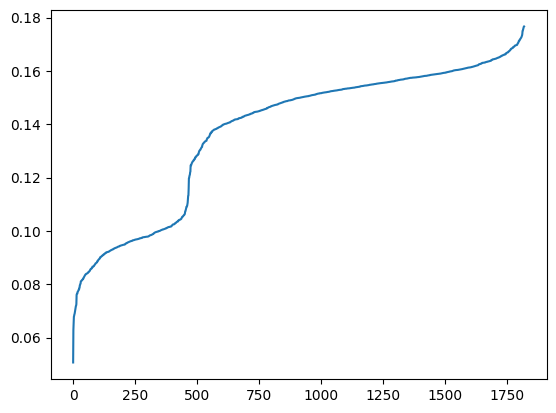

In [73]:
plt.plot(sorted(scores.values()))

In [89]:
best_community = {c: communities[c] for c in best_comb}

f1 = NF1(best_community, ground_truth_communities).get_f1()

print(f'F1 score is {f1}')

jacc = calc_jaccard (num_nodes, best_community, ground_truth_communities)

print(f'Jaccard coeff is {jacc}')



F1 score is 0.37416666666666665
Jaccard coeff is 0.24721539803845888
